# Implement Model from https://academic.oup.com/cercor/article/27/4/2513/3056352

Papadimitriou, C., White, R. L., & Snyder, L. H. (2017). Ghosts in the machine ii: Neural correlates of memory interference from the previous trial. Cerebral Cortex, 27(4), 2513-2527.


In [217]:
import numpy as np
import matplotlib.pyplot as plt
pi=np.pi

In [207]:
u_space = 100
stp_sz = 1
xx = np.arange(-u_space,u_space,stp_sz)
x,y = np.meshgrid(xx,xx)
n_step = len(x)
nRF = 6
buf = u_space/nRF
rfl = np.linspace(-u_space+buf,u_space-buf,nRF)
RFL = np.meshgrid(rfl,rfl)

In [208]:
def RF(x,y,ux=0,uy=0,sig=8):
    return np.exp(-((x-ux)**2+(y-uy)**2)/(2*sig**2))

In [209]:
BRF = np.zeros(x.shape)
sRF =  np.zeros((n_step,n_step,nRF,nRF))
for i in range(nRF):
    for j in range(nRF):
        BRF+=RF(x,y,RFL[0][i,j],RFL[1][i,j])
        sRF[:,:,i,j] = RF(RFL[0][i,j],RFL[1][i,j])

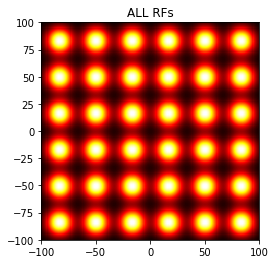

In [210]:
plt.imshow(BRF,cmap='hot',extent=(-u_space,u_space,-u_space,u_space))
plt.title('ALL RFs')
plt.show()

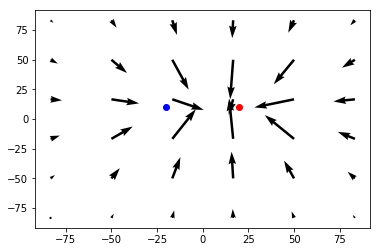

In [438]:
a=-.05
b=20
T_curr = (20,10) # Tx, Ty
T_prev = (-20,10)
c_curr=.6
c_prev=.2

def d(RF,T): return np.sqrt((RF[0]-T[0])**2 + (RF[1]-T[1])**2)
def s(d,a=-.05,b=20): return 1/(1+np.exp(-1*(d-b))) # text: "s(d)"
def M(T,R,d): return (T-R)/(1+np.exp(-a*(d-b)))

def g_move(RFL,T):
    d_all = d(RFL,T)
    Mx = (T[0]-RFL[0])/(1+np.exp(-a*(d_all-b)))
    My = (T[1]-RFL[1])/(1+np.exp(-a*(d_all-b)))
    return np.stack((Mx,My))

t_move  =  c_prev*g_move(RFL,T_prev)+  c_curr*g_move(RFL,T_curr)

plt.quiver(RFL[0],RFL[1],t_move[0],t_move[1])
plt.plot(T_curr[0],T_curr[1],'ro')
plt.plot(T_prev[0],T_prev[1],'bo')
plt.show()



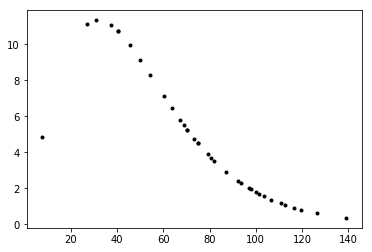

In [458]:
T = (20,10)
d_all = d(RFL,T)
Mx = (T[0]-RFL[0])/(1+np.exp(-a*(d_all-b)))
My = (T[1]-RFL[1])/(1+np.exp(-a*(d_all-b)))
Ma = np.sqrt(Mx**2+My**2)
plt.plot(d_all,Ma,'k.')
plt.show()

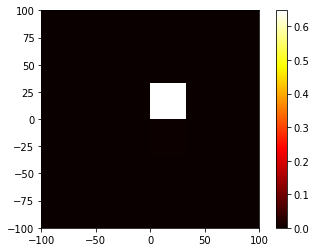

In [241]:
ENC = RF(T_curr[0],T_curr[1],RFL[0],RFL[1])
plt.imshow(ENC,origin='lower',cmap='hot',extent=(-u_space,u_space,-u_space,u_space))
plt.colorbar()
plt.show()

In [242]:
#  decode 
ENCn = ENC/np.sum(ENC)
dec = np.sum(ENCn*RFL[0]+ 1j*ENCn*RFL[1])
dec = [np.real(dec), np.imag(dec)]
print(dec,T_curr)

[16.697770627194423, 16.48547520273475] (20, 10)


# Lets move into circular space to see if things make sense there...

In [627]:
def angle(s_0,s_1):
    d = s_0-s_1
    d[np.abs(d)>pi]-= 2*pi*np.sign(d[np.abs(d)>pi])
#     d[np.abs(d)>90]-= 180*np.sign(d[np.abs(d)>90])
    return d

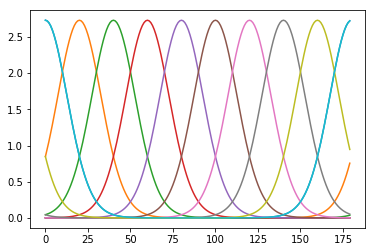

In [628]:
# Try using circ gaussian RFs that can shift w/ circular attention.

n_view = 180
theta = np.linspace(-pi,pi-(2*pi/n_view),n_view)
n_neurons = 10 # n-neurons
gamma = .5 #  gain
kappa = 5  # how precise tuning curves
psi = np.linspace(-pi,pi,n_neurons) # neuron selectivity
fi = np.zeros((n_view,n_neurons))
for i in range(n_neurons):
    fi[:,i] = (gamma/n_neurons) * np.exp(kappa*np.cos(theta-psi[i])-1)
    
plt.plot(fi)
plt.show()

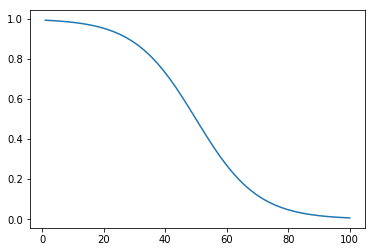

In [379]:
a=-.1
b = 50
tmp = np.linspace(1,100)
foo = 1/(1+np.exp(-a*(tmp-b)))
plt.plot(tmp,foo)
plt.show()

# Need receptive fields to shift toward stimulus
1. get  d-ang to track work at different orientations
1. get shifts to follow reasonable shape given d-ang

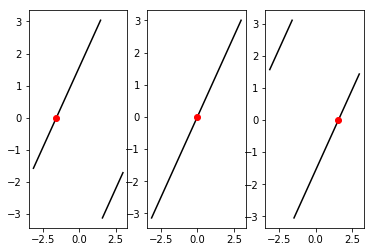

In [392]:
T = pi/2
Tu = [-pi/2,0,pi/2]
for i in range(3):
    T =  Tu[i]
    plt.subplot(1,3,i+1)
    psi = np.linspace(-pi,pi-.01)
    d_ang = angle(psi,T)
    order = np.argsort(d_ang)
    psi[-1] = np.nan
    plt.plot(psi[order],d_ang[order],'k')
    plt.plot(T,0,'ro')

plt.show()

# Shift as a function of d_ang
- want to be smooth and smallest right at stimulus and furthest away (approaching 0)
- want to peak ~20 degrees and go to zero

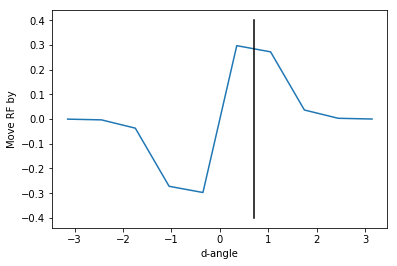

In [637]:
# psi = np.linspace(-pi,pi-.01)
psi = np.linspace(-pi,pi,n_neurons) # neuron selectivity
oo = np.array([-1,1])
zz = np.array([1,1])

T = 0
a=-4
b = pi/4
c= 1

d_ang = angle(psi,T)
d_anga = np.abs(d_ang)
def g_mvby(T):
    d_ang = angle(psi,T)
    d_anga = np.abs(d_ang)
    return (d_ang)/(1+np.exp(-a*(d_anga-b)))

mv_by = g_mvby(T)
plt.plot(d_ang,mv_by)
plt.plot(zz*20/90*pi,oo*.4,'k')
plt.xlabel('d-angle')
plt.ylabel('Move RF by')
plt.show()

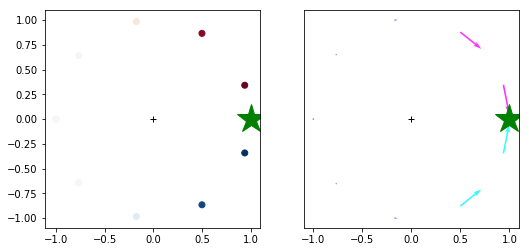

In [638]:
T = 0
mv_by = g_mvby(T)
plt.figure(figsize=(8.5,4))
plt.subplot(121)
plt.scatter(x=np.cos(psi),y=np.sin(psi),c=mv_by,cmap='RdBu_r')
plt.plot(np.cos(T),np.sin(T),'g*',markersize=30)
plt.plot(0,0,'k+')

plt.subplot(122)
psi_n = psi-mv_by
start = np.stack([np.cos(psi),np.sin(psi)])
end  =  np.stack([np.cos(psi_n),np.sin(psi_n)])
d_pos = end-start

plt.quiver(start[0],start[1],d_pos[0],d_pos[1],mv_by,angles='xy', scale_units='xy', scale=1,alpha=.8,cmap='cool')
plt.plot(np.cos(T),np.sin(T),'g*',markersize=30)
plt.plot(0,0,'k+')
plt.yticks([])
plt.show()

In [636]:
psi_n.shape

(50,)

# Now  with shifted (and  non-shifted) receptive fields, lets do 
* encoding
* decoding

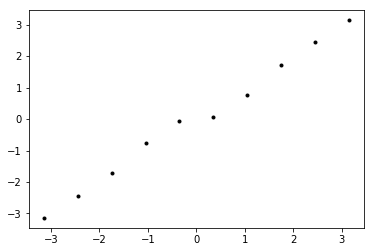

In [639]:
plt.plot(psi,psi_n,'k.')

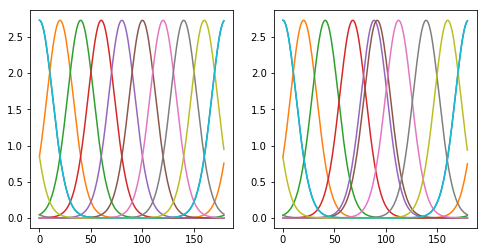

In [640]:
# encoding, first get RFs

fi = np.zeros((n_view,n_neurons))
fi_s = np.zeros((n_view,n_neurons))
for i in range(n_neurons):
    fi[:,i] = (gamma/n_neurons) * np.exp(kappa*np.cos(theta-psi[i])-1)

for i in range(n_neurons):
    fi_s[:,i] = (gamma/n_neurons) * np.exp(kappa*np.cos(theta-psi_n[i])-1)
    
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(fi)
plt.subplot(122)
plt.plot(fi_s)
plt.show()

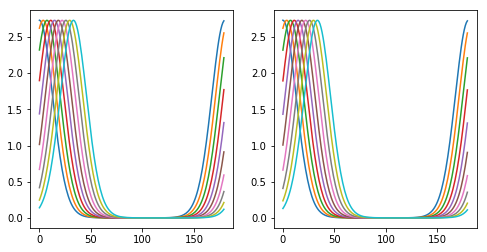